# Exercise 4

This week we will practice how to do **data classification and aggregation in Geopandas**. We continue from the last week's exerise with rather similar idea. In this exercise we use data from the [Helsinki Region Travel Time Matrix](https://blogs.helsinki.fi/accessibility/helsinki-region-travel-time-matrix/) as input.


## Problem 1: Join accessibility datasets into a grid and visualize them by using a classifier (10 points)


![P1 example result](img/traveltimes_example.png)

*Desired output from problem 1: Travel times by public transport (PT) and car to Itis and Myyrmanni*

**Data:**

[data/](data/) directory contains all the required input data for this exercise:
 
- Travel time data: `travel_times_to_[XXXXXXX]_[NAME-OF-THE-CENTER].txt` (Travel times and distances in the Helsinki Region to different shopping centers  as text files)
- Reference grid: `MetropAccess_YKR_grid_EurefFIN.shp`. 

Column `from_id` in the travel time data sets corresponds to the `YKR_ID` column in the grid shapefile.
     
**Steps:**

In problem 1 we will focus on travel times to **Itis** and **Myyrmanni**. Our goal is to visualize travely times by public transport and car to both shopping centers. Before plotting the maps we need to classify the data. Your task is to **first develop the processing steps using Itis as input**, and then repeat the steps for Myyrmanni.

- Read the Polygon grid `MetropAccess_YKR_grid_EurefFIN.shp` into a GeoDataFrame called `grid` using geopandas:

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# filepath to grid file
fp_grid = r'data\MetropAccess_YKR_grid_EurefFIN.shp'

# import geodf object
grid = gpd.read_file(fp_grid)

In [2]:
# NON-EDITABLE TEST CELL
# Check the data
print("\nYKR GRID:", len(grid), "rows")


YKR GRID: 13231 rows


- Read the travel time data file for Itis using Pandas into a variable called `data`. Separator is `";"` in the input file.
- Select only following columns from the file:
    
   - `pt_r_t`
   - `car_r_t`
   - `from_id`
   - `to_id`

In [3]:
# filepath to text file
fp_data = r'data\TravelTimes_to_5944003_Itis.txt'

# import pandas df
data = pd.read_csv(fp_data, sep=';')

# specify cols of interest
cols = ['pt_r_t', 'car_r_t', 'from_id', 'to_id']

# refine selection
data = data[cols]

In [4]:
# NON-EDITABLE TEST CELL
# Check the data
print("\nITIS:", len(data), "rows")


ITIS: 13231 rows


- join attributes from `data` to `grid` using the [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) function: 
  - **`YKR_ID`** -column in `grid` corresponds to the **`from_id`** column in `data`
  - store the join output into a variable called `data_geo` 

In [5]:
# merge geo df with df so that we keep geometry 
data_geo = grid.merge(data, left_on='YKR_ID', right_on='from_id', how='inner')
data_geo.head(3)

,x,y,YKR_ID,geometry,pt_r_t,car_r_t,from_id,to_id
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",132,50,5785640,5944003
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",135,51,5785641,5944003
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",137,58,5785642,5944003


In [6]:
# NON-EDITABLE TEST CELL
#Check data type
assert type(data_geo)  == gpd.geodataframe.GeoDataFrame, "output should be a geodataframe"

In [7]:
# NON-EDITABLE TEST CELL
# Check that the merged output have (at least) the necessary columns
required_columns = ['YKR_ID', 'pt_r_t', 'car_r_t', 'geometry']

assert all(x in data_geo.columns for x in required_columns), "Couldn't find all required columns"

- Remove all rows containing no-data values (-1) from `data_geo`. You can for example [replace](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html) the no-data values with numpy's `np.nan`, and then drop rows containing no-data values using the [DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) function.

In [8]:
import numpy as np

# replace -1 with NaN
data_geo.replace(-1, np.nan, inplace=True)

# drop NaN records
data_geo.dropna(axis=0, inplace=True)

# print a couple of checks
print('Number of recs: ', len(data_geo))
print(data_geo.head(3))

Number of recs:  13020
          x          y   YKR_ID  \
0  381875.0  6697880.0  5785640   
1  382125.0  6697880.0  5785641   
2  382375.0  6697880.0  5785642   

                                            geometry  pt_r_t  car_r_t  \
0  POLYGON ((382000.000 6697750.000, 381750.000 6...   132.0     50.0   
1  POLYGON ((382250.000 6697750.000, 382000.000 6...   135.0     51.0   
2  POLYGON ((382500.000 6697750.000, 382250.000 6...   137.0     58.0   

   from_id      to_id  
0  5785640  5944003.0  
1  5785641  5944003.0  
2  5785642  5944003.0  


In [9]:
# NON-EDITABLE TEST CELL
# Check that -1 values are not present in the columns
assert -1 not in data_geo["pt_r_t"], "No data values should be removed from the data!"


- Classify the travel times for both travel modes (public transport and private car) into five-minute intervals 
    - Create a `UserDefined` classifier using the [pysal/mapclassify](https://github.com/pysal/mapclassify#userdefined) library using these class breaks: `5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60`
    - Apply the classifier to `pt_r_t` and `car_r_t` columns and store the results to `pt_r_t_cl` and `car_r_t_cl` columns, respectively
    - Notice that these 12 class breaks will produce 13 classes (as 1 class break divides the data into two.

In [18]:
# import libraries
import mapclassify

# define class intervals
class_breaks = [5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]

# create new cols to store results
data_geo['pt_r_t_cl'] = None
data_geo['car_r_t_cl'] = None

# define a classifier
classifier = mapclassify.UserDefined.make(bins=class_breaks)

# classify data
data_geo['pt_r_t_cl'] = data_geo[['pt_r_t']].apply(classifier)
data_geo['car_r_t_cl'] = data_geo[['car_r_t']].apply(classifier)                           

data_geo[['pt_r_t', 'car_r_t', 'pt_r_t_cl', 'car_r_t_cl']].head()


,pt_r_t,car_r_t,pt_r_t_cl,car_r_t_cl
0,132.0,50.0,12,9
1,135.0,51.0,12,10
2,137.0,58.0,12,11
3,141.0,57.0,12,11
4,125.0,50.0,12,9


In [19]:
# NON-EDITABLE TEST CELL
#Check the output
print("travel times by public transport:")
print(data_geo[['YKR_ID', 'pt_r_t', 'pt_r_t_cl']].head())

travel times by public transport:
    YKR_ID  pt_r_t  pt_r_t_cl
0  5785640   132.0         12
1  5785641   135.0         12
2  5785642   137.0         12
3  5785643   141.0         12
4  5787544   125.0         12


In [20]:
# NON-EDITABLE TEST CELL
#Check the output
print("Travel times by car:")
print(data_geo[['YKR_ID','car_r_t', 'car_r_t_cl']].head())

Travel times by car:
    YKR_ID  car_r_t  car_r_t_cl
0  5785640     50.0           9
1  5785641     51.0          10
2  5785642     58.0          11
3  5785643     57.0          11
4  5787544     50.0           9


**Plot the classified travel times to Itis**:

![itis_example.png](img/itis_example.png)

Create a 1x2 plot where the you plot travel times by public transport and travel times by car to Itis:
- Create subplots using matplotlib having 1 row and 2 columns (use parameters `nrows` & `ncols`), and the figure size should be 10 inches by 5 inches (use parameter `figsize`)
- Add titles for the subplots as seen in the example above
- Remove the empty whitespace around the plots using function `plt.tight_layout()`
- Save the figure into disk with filename `itis_accessibility.png`


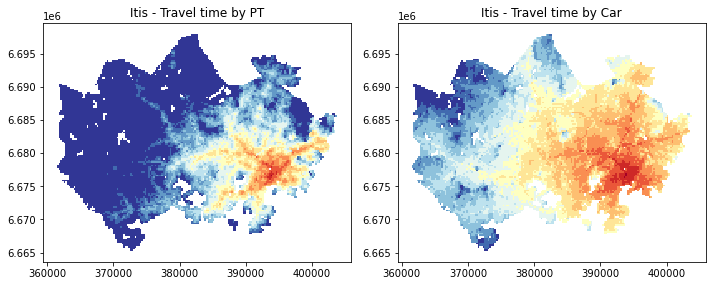

In [23]:
# Define output filename for the figure in here and use it when saving the file:
output_fig1 = "itis_accessibility.png"

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

data_geo.plot(ax=ax[0], column='pt_r_t_cl', cmap="RdYlBu")
ax[0].set_title('Itis - Travel time by PT')

data_geo.plot(ax=ax[1], column='car_r_t_cl', cmap="RdYlBu")
ax[1].set_title('Itis - Travel time by Car')

plt.tight_layout()

plt.savefig(output_fig1);


In [24]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig1), "figure does not exists!"

**Repeat the steps for Myyrmanni:**

![myyrmanni example figure](img/myyrmanni_example.png)

Next, your task is to repeat all the same steps for **Myyrmanni** (`data/TravelTimes_to_5902043_Myyrmanni.txt`):

    # Read text file using pandas into a variable called data
    # Select columns 'pt_r_t', 'car_r_t', 'from_id', 'to_id'
    # Make table join between grid and travel time data. Store output in a variable called data_geo
    # Remove no data values
    # Classify the values in columns 'pt_r_t', 'car_r_t' into new columns 'pt_r_t_cl', 'car_r_t_cl'
    # Plot travel times by public transport and travel times by car.
    # Save output image to file (myyrmanni_accessibility.png)

*Hint: You can copy paste the code from your earlier solutions in here, just change the input file path.*


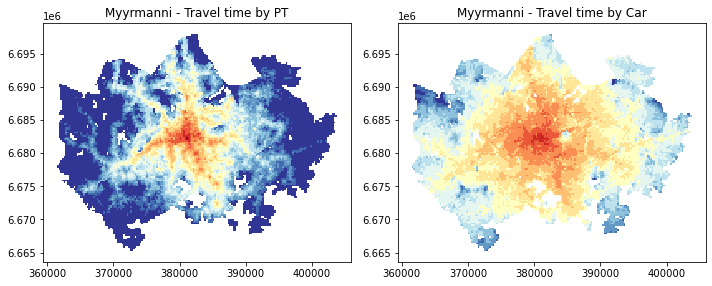

In [25]:
# specify filepath to grid file
fp_grid = r'data\MetropAccess_YKR_grid_EurefFIN.shp'

# import grid file as geodf
grid = gpd.read_file(fp_grid)

# specify filepath to text file
fp_data = r'data\TravelTimes_to_5902043_Myyrmanni.txt'

# import txt file as pandas obj
data = pd.read_csv(fp_data, sep=';')

# specify cols of interest
cols = ['pt_r_t', 'car_r_t', 'from_id', 'to_id']

# keep columns of interest
data = data[cols]

# merge two datasets, where grid is the master file
data_geo = grid.merge(data, left_on='YKR_ID', right_on='from_id', how='inner')

# replace '-1' values with NaN
data_geo.replace(-1, np.nan, inplace=True)

# drop NaN records by rows
data_geo.dropna(axis=0, inplace=True)

# define intervals for user-defined classification
class_breaks = [5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]

# create new cols to store results
data_geo['pt_r_t_cl'] = None
data_geo['car_r_t_cl'] = None

# define a classifier
classifier = mapclassify.UserDefined.make(bins=class_breaks)

# apply classifier to specific cols
data_geo['pt_r_t_cl'] = data_geo[['pt_r_t']].apply(classifier)
data_geo['car_r_t_cl'] = data_geo[['car_r_t']].apply(classifier)                           

output_fig2 = "myyrmanni_accessibility.png"

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

data_geo.plot(ax=ax[0], column='pt_r_t_cl', cmap="RdYlBu")
ax[0].set_title('Myyrmanni - Travel time by PT')

data_geo.plot(ax=ax[1], column='car_r_t_cl', cmap="RdYlBu")
ax[1].set_title('Myyrmanni - Travel time by Car')

plt.tight_layout()

plt.savefig(output_fig2);


In [26]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
import os
assert os.path.isfile(output_fig2), "figure does not exists!"


**Optional:  4-panel figure** (+2 extra points available if you choose to do this)

As an optional task, plot travel times to Itis and Myyrmanni all in one 4-panel figure (see example at the top of this page)!

Hints:
- create a for-loop where you repeat all the steps for Itis and Myyrmanni (you can iterate over a list of input filepaths)
- Before the for-loop, create a figure with 4 subplots (2 rows and 2 columns) and use figsize=(10,10)
- Inside the for-loop, plot each map into one of the subplots. 
- save the figure as `shopping_center_accessibility.png` 

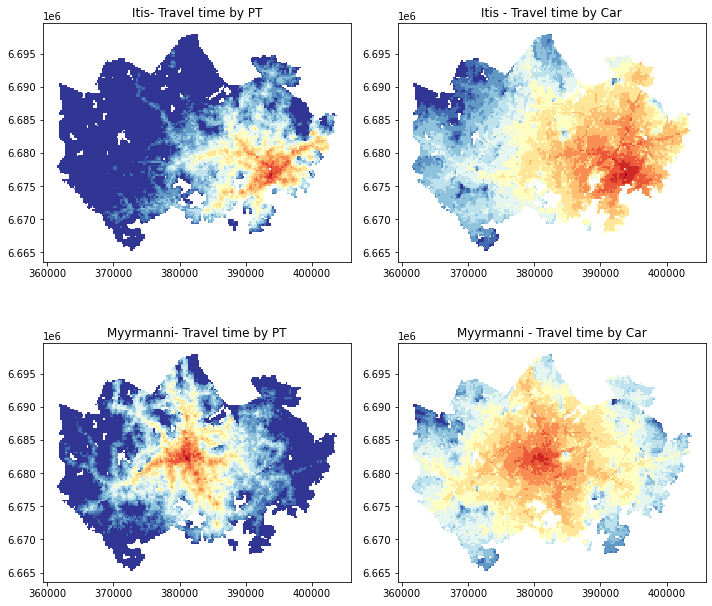

In [44]:
output_fig = 'shopping_center_accessibility.png'

files = [r'data\TravelTimes_to_5944003_Itis.txt', r'data\TravelTimes_to_5902043_Myyrmanni.txt']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# filepath to grid file
fp_grid = r'data\MetropAccess_YKR_grid_EurefFIN.shp'

# import geodf object
grid = gpd.read_file(fp_grid)

# specify cols of interest
cols = ['pt_r_t', 'car_r_t', 'from_id', 'to_id']

# define class intervals
class_breaks = [5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]

# define a classifier
classifier = mapclassify.UserDefined.make(bins=class_breaks)

for (row, f) in enumerate(files):    
    
    # import pandas df
    data = pd.read_csv(f, sep=';')

    # refine selection
    data = data[cols]

    # merge grid geodf with travel time df
    data_geo = grid.merge(data, left_on='YKR_ID', right_on='from_id', how='inner')

    # replace -1 with NaN
    data_geo.replace(-1, np.nan, inplace=True)

    # drop NaN records
    data_geo.dropna(axis=0, inplace=True)

    # create new cols to store results
    data_geo['pt_r_t_cl'] = None
    data_geo['car_r_t_cl'] = None

    # classify data
    data_geo['pt_r_t_cl'] = data_geo[['pt_r_t']].apply(classifier)
    data_geo['car_r_t_cl'] = data_geo[['car_r_t']].apply(classifier)
    
    data_geo.plot(ax=ax[row][0], column='pt_r_t_cl', cmap="RdYlBu")
    data_geo.plot(ax=ax[row][1], column='car_r_t_cl', cmap="RdYlBu")    
   
    if row == 0:
        city='Itis'
    else:
        city='Myyrmanni'
    
    ax[row, 0].set_title('%s- Travel time by PT' % city)
    ax[row, 1].set_title('%s - Travel time by Car' % city)

    plt.tight_layout()

plt.savefig(output_fig);

**Finally**, check that you have provided adequate comments in your code. If you have any thoughts about this exercise, you can write them in here:


I liked this exercise.

### Done!


**Remember to commit the output figures** to your exercise repository! (One for Itis and one for Myyrmanni, or optionally a combined 4-panel figure for both shopping centers and both travel modes).

That's it, once you have plotted the data and saved the output you are ready to continue with Problem 2.